# Aprimorando o modelo de regressão

---

O post e modelo inicial está neste [link](https://github.com/barbosarafael/Projetos/blob/master/House%20Prices%20-%20Advanced%20Regression%20Techniques/notebook_house_prices.ipynb) no github.

Aqui iremos melhorar o workflow e utilizaremos o `pipeline` do `sklearn` para deixar mais simples os processos.

Desde já agradecendo ao [post](https://medium.com/data-hackers/como-usar-pipelines-no-scikit-learn-1398a4cc6ae9) que mostra basicamente todas as opções.

# Bibliotecas utilizadas

---

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import pipeline

plt.style.use("seaborn-muted")
%matplotlib inline

# Baixando os dados 

---

In [19]:
treino = pd.read_csv(filepath_or_buffer = "train.csv")
teste = pd.read_csv(filepath_or_buffer = "test.csv")

# Manuseio nos dados

---

## `Log` nos dados e colocando em uma variável separada

In [20]:
treino["SalePrice"] = np.log(treino["SalePrice"])

var_venda = treino["SalePrice"]

## Concatenando os dados de treino e teste

In [21]:
treino.drop(["SalePrice"], axis = 1, inplace = True)

In [22]:
treino_index = treino.shape[0]

In [23]:
teste_index = teste.shape[0]

In [24]:
banco_geral = pd.concat(objs = [treino, teste], axis = 0).reset_index(drop = True)

banco_geral

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2914,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
2915,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
2916,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
2917,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


## Selecionando as quantitativas

---

In [25]:
banco_geral_quant = banco_geral[["YearBuilt", "YearRemodAdd", "TotalBsmtSF", "1stFlrSF", "GrLivArea", "FullBath", "TotRmsAbvGrd", "GarageArea"]]

banco_geral_quant.head()

,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,GrLivArea,FullBath,TotRmsAbvGrd,GarageArea
0,2003,2003,856.0,856,1710,2,8,548.0
1,1976,1976,1262.0,1262,1262,2,6,460.0
2,2001,2002,920.0,920,1786,2,6,608.0
3,1915,1970,756.0,961,1717,1,7,642.0
4,2000,2000,1145.0,1145,2198,2,9,836.0


## Trocar tipo de variáveis

---

In [26]:
banco_geral["MSSubClass"] = banco_geral["MSSubClass"].astype(str)
banco_geral["OverallQual"] = banco_geral["OverallQual"].astype(str)
banco_geral["OverallCond"] = banco_geral["OverallCond"].astype(str)

## Dados nulos

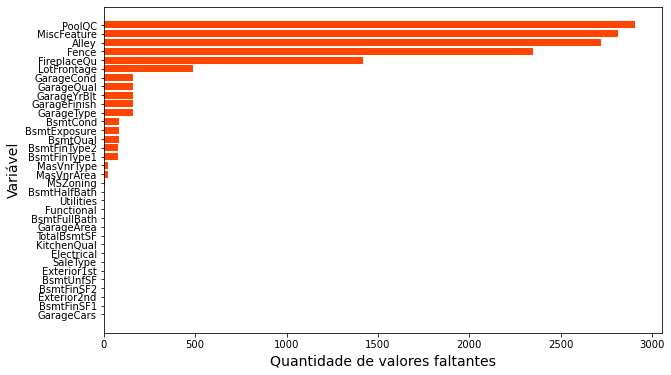

In [27]:
miss_val = banco_geral.isnull().sum().sort_values(ascending = False)

dados_miss_val = pd.DataFrame(miss_val)

dados_miss_val = dados_miss_val.reset_index()

dados_miss_val.columns = ["Variável", "Quantidade"]

dados_miss_val = dados_miss_val[dados_miss_val["Quantidade"] > 0].sort_values(by = "Quantidade")

#-------------------------

plt.figure(figsize = [10, 6])
plt.barh(dados_miss_val["Variável"], dados_miss_val["Quantidade"], align = "center", color = "orangered")
plt.xlabel("Quantidade de valores faltantes", fontsize = 14, color = "black")
plt.ylabel("Variável", fontsize = 14, color = "black")
plt.tick_params(axis = "x", labelcolor = "black")
plt.tick_params(axis = "y", labelcolor = "black")
plt.show()

---

Vamos exlcuir as top5 variáveis que mais possuem valores faltantes.

In [28]:
banco_geral = banco_geral.drop(["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"], axis = 1)

banco_geral.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,LotShape,LandContour,Utilities,LotConfig,...,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1,60,RL,65.0,8450,Pave,Reg,Lvl,AllPub,Inside,...,61,0,0,0,0,0,2,2008,WD,Normal
1,2,20,RL,80.0,9600,Pave,Reg,Lvl,AllPub,FR2,...,0,0,0,0,0,0,5,2007,WD,Normal
2,3,60,RL,68.0,11250,Pave,IR1,Lvl,AllPub,Inside,...,42,0,0,0,0,0,9,2008,WD,Normal
3,4,70,RL,60.0,9550,Pave,IR1,Lvl,AllPub,Corner,...,35,272,0,0,0,0,2,2006,WD,Abnorml
4,5,60,RL,84.0,14260,Pave,IR1,Lvl,AllPub,FR2,...,84,0,0,0,0,0,12,2008,WD,Normal


In [41]:
from sklearn.preprocessing import StandardScaler


standard_transformer = pipeline(steps=[
        ('standard', StandardScaler())
])

TypeError: 'module' object is not callable